#  <center> Speech Emotion Recognition <center>

In [1]:
import pandas as pd
import numpy as np

import os
import sys
import random

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import adam_v2
from keras.layers import Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)
ravdess_directory_list

['Actor_02',
 'Actor_17',
 'Actor_05',
 'Actor_16',
 'Actor_21',
 'Actor_01',
 'Actor_11',
 'Actor_20',
 'Actor_08',
 'Actor_15',
 'Actor_06',
 'Actor_12',
 'Actor_23',
 'Actor_24',
 'Actor_22',
 'Actor_04',
 'Actor_19',
 'Actor_10',
 'Actor_09',
 'Actor_14',
 'Actor_03',
 'Actor_13',
 'Actor_18',
 'Actor_07']

In [4]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_statement = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that auido.
        file_emotion.append(int(part[2]))
        file_statement.append(int(part[4]))
        file_path.append(Ravdess + dir + '/' + file)
        

Ravdess_df = pd.DataFrame({"Emotions":file_emotion, "Statement":file_statement, "Path":file_path})

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Statement,Path
0,surprise,1,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,1,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,1,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,1,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,2,/kaggle/input/ravdess-emotional-speech-audio/a...


In [5]:
Ravdess_df.groupby(['Emotions','Statement']).size().unstack()

Statement,1,2
Emotions,,
angry,96,96
calm,96,96
disgust,96,96
fear,96,96
happy,96,96
neutral,48,48
sad,96,96
surprise,96,96


In [6]:
# creating a copy
data_path = Ravdess_df[['Emotions','Path']].copy()
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...



## Data Visualisation ------------------

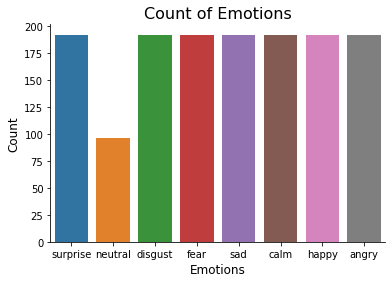

In [7]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Plotting waveplots and spectograms for audio signals.

In [8]:
def create_waveplot(data, sr):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

Check for audio and try to adjust it to model prepared in next step

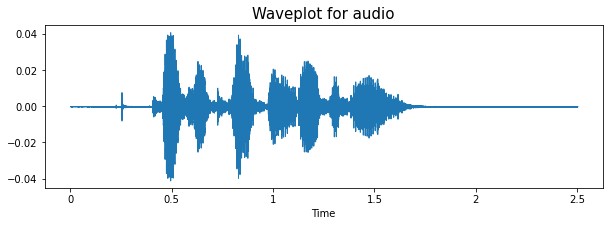

In [9]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav"
data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)
create_waveplot(data, sampling_rate)
Audio(data=data, rate=sampling_rate)

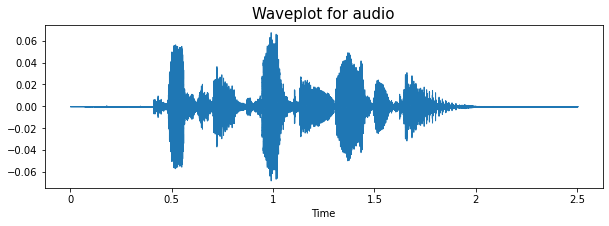

In [10]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_03/03-01-01-01-01-01-03.wav"
data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)
create_waveplot(data, sampling_rate)
Audio(data=data, rate=sampling_rate)

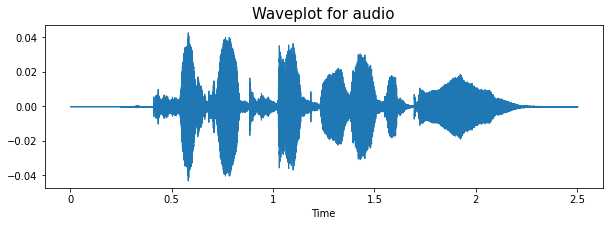

In [11]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-04-01-01-01-02.wav"
data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)
create_waveplot(data, sampling_rate)
Audio(data=data, rate=sampling_rate)

## Data Augmentation

In [12]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

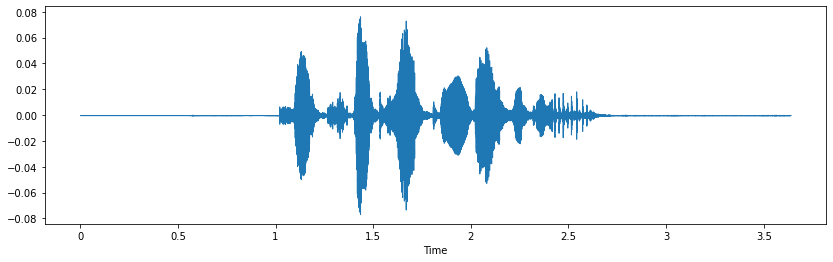

In [13]:
#1. Simple Audio
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

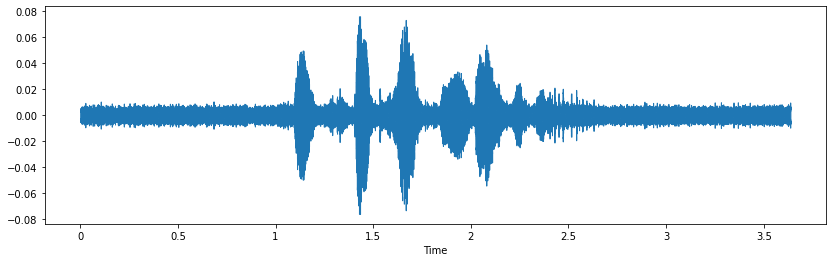

In [14]:
#2. Noise Injection
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

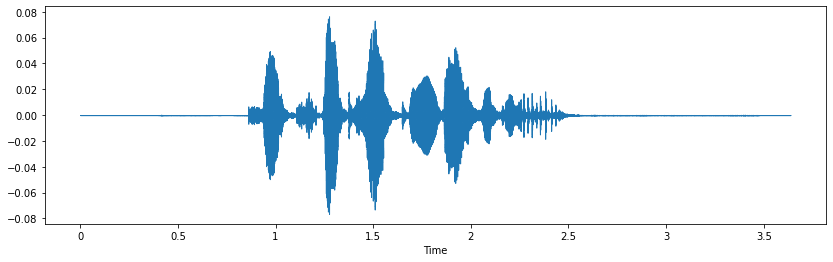

In [15]:
# 3. Shifting
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

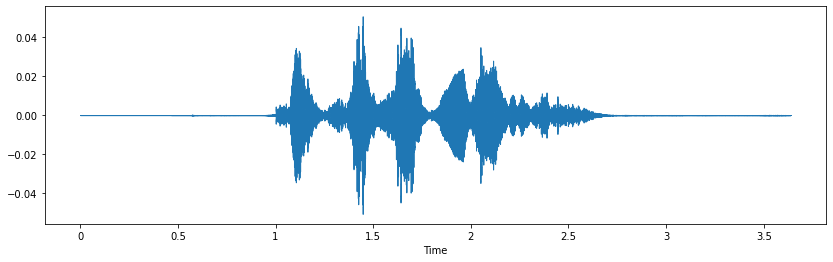

In [16]:
# 4. Pitch
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction

In [17]:
# funtion to transform audio
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# function to do extraction of features of audio
def extract_features(data, sr=44100):
    # Zero Crossing Rate
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, mfcc))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, mel))

    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, tonnetz))
    return result

# function to do extraction of features of audio for sequence
def extract_features_for_sequence(data, sr=44100):
    # MFCC with sequential return
    result = librosa.feature.mfcc(y=data, sr=sr)
    
    return result

# function to get features of audio
def get_features(path, sampling_rate=44100):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    fn0_data = data
    res0 = extract_features(fn0_data)
    result = np.array([res0])

    fn1_data = noise(data)
    res1 = extract_features(fn1_data)
    result = np.vstack((result, res1))

    fn2_data = shift(data)
    res2 = extract_features(fn2_data)
    result = np.vstack((result, res2))

    fn3_data = pitch(data, sampling_rate)
    res3 = extract_features(fn3_data)
    result = np.vstack((result, res3))

    return result

# function to get features of audio for sequence training
def get_features_for_sequence(path, sampling_rate=44100):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    fn0_data = data
    res0 = extract_features_for_sequence(fn0_data)
    result = [res0]

    fn1_data = noise(data)
    res1 = extract_features_for_sequence(fn1_data)
    result.append(res1)

    fn2_data = shift(data)
    res2 = extract_features_for_sequence(fn2_data)
    result.append(res2)

    fn3_data = pitch(data, sampling_rate)
    res3 = extract_features_for_sequence(fn3_data)
    result.append(res3)

    return result

### Check for dataset used for CNN

In [18]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-02-01.wav"
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
testfeature = extract_features(data, sample_rate)
testfeature.shape

(167,)

In [19]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav"
feature = get_features(path)
feature.shape

(4, 167)

### Check for dataset used for RNN

In [20]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-02-01.wav"
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
feature_sequence = extract_features_for_sequence(data, sample_rate)
feature_sequence.shape

(20, 108)

In [21]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav"
feature_sequence = get_features_for_sequence(path)
feature_sequence

[array([[-8.7664856e+02, -8.7664856e+02, -8.7664856e+02, ...,
         -8.7525128e+02, -8.7625079e+02, -8.7579797e+02],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.9678757e+00,  5.6054229e-01,  1.1999005e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.9434264e+00,  5.5484664e-01,  1.1910532e+00],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          2.8557181e-01,  9.9369347e-02,  4.6132323e-01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.4657804e-01,  5.4194808e-02,  3.8580745e-01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.0211900e-02,  8.7772459e-03,  3.0906594e-01]], dtype=float32),
 array([[-5.44020873e+02, -5.11413391e+02, -5.13502513e+02, ...,
         -5.06949245e+02, -5.08732913e+02, -5.21605038e+02],
        [-5.00251336e+00, -1.77993441e+00, -5.77513297e+00, ...,
         -4.18928572e+00, -2.62086013e+00, -1.03394201e+01]

In [22]:
feature_sequence[0].shape, feature_sequence[1].shape, feature_sequence[2].shape, feature_sequence[3].shape

((20, 108), (20, 108), (20, 108), (20, 108))

## Extract feature

### Extract feature for dataset used for CNN

In [23]:
# extract feature of all audio
X, Y = [], []
foul_count = 0
# test_count = 0
for path, emotion in zip(data_path.Path.to_list(), data_path.Emotions.to_list()):
    feature = get_features(path)
    for ele in feature:
        if ele.shape == (167, ):
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
        else:
            print(ele.shape)
#     test_count += 1
#     if test_count == 50:
#         break;
print(f"{foul_count} invalid data")

0 invalid data


In [24]:
len(X), len(Y), X[0].shape, Y[0], data_path.Path.shape

(5760, 5760, (167,), 'surprise', (1440,))

In [25]:
dfm = pd.DataFrame()
xx = pd.Series(X)
for i in range(167):
    dfm[i] = [k[i] for k in xx]

In [26]:
Features = dfm.copy()
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,labels
0,0.231174,0.659908,0.641967,0.581459,0.533789,0.510536,0.619317,0.651697,0.642230,0.647820,...,4.131763e-07,8.152433e-08,4.127055e-09,-0.041734,0.011062,-0.032262,-0.007599,0.017248,0.008238,surprise
1,0.306238,0.687226,0.692440,0.662080,0.638786,0.639111,0.688113,0.701081,0.688603,0.682644,...,2.084486e-06,1.469839e-06,1.264242e-06,-0.017480,-0.003355,-0.026433,-0.018333,0.005785,0.001055,surprise
2,0.231188,0.657729,0.642875,0.583481,0.534419,0.512634,0.619936,0.652534,0.642491,0.649345,...,8.727064e-07,1.109687e-07,3.615364e-09,-0.045302,0.022826,-0.046830,-0.006885,0.020280,0.010906,surprise
3,0.174651,0.666062,0.648282,0.570460,0.503228,0.505591,0.632947,0.651453,0.627575,0.654856,...,1.927688e-07,3.351903e-08,7.288334e-10,0.025709,-0.034753,0.023025,-0.011892,-0.000485,-0.012311,surprise
4,0.239882,0.594655,0.553910,0.568559,0.584042,0.577901,0.591094,0.637172,0.684707,0.665465,...,1.733833e-08,3.504725e-09,1.339002e-10,-0.044781,0.025309,0.021449,-0.046973,0.014728,0.005113,neutral


In [27]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((5760, 167), (5760,))

### Extract feature for dataset used for RNN

In [28]:
# # extract feature of all audio
# X_seq, Y_seq = [], []
# foul_count = 0
# # test_count = 0
# for path, emotion in zip(data_path.Path.to_list(), data_path.Emotions.to_list()):
#     feature = get_features_for_sequence(path)
#     for ele in feature:
#         if ele.shape == (20, 108):
#             X_seq.append(ele)
#             # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
#             Y_seq.append(emotion)
#         else:
#             print(ele.shape)
#             foul_count += 1
# #     test_count += 1
# #     if test_count == 20:
# #         break;
# print(f"{foul_count} invalid data")

In [29]:
# len(X_seq), len(Y_seq), data_path.Path.shape

In [30]:
# X_seq[0]

# CNN Modelling


## Data Preparation

In [31]:
Y_nparray = np.array(Y).reshape(-1,1)
Y_nparray

array([['surprise'],
       ['surprise'],
       ['surprise'],
       ...,
       ['angry'],
       ['angry'],
       ['angry']], dtype='<U8')

One Hot Encode will make labels like this:

{
    0: 'angry',
    1: 'calm',
    2: 'disgust',
    3: 'fear',
    4: 'happy',
    5: 'neutral',
    6: 'sad',
    7: 'surprise'
}

In [32]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
pd.DataFrame(Y).head()

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
Y.shape

(5760, 8)

In [34]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4032, 167), (1728, 167), (4032, 8), (1728, 8))

In [35]:
# making data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4032, 167, 1), (4032, 8), (1728, 167, 1), (1728, 8))

## Modelling

In [36]:
input_shape = x_train.shape[1:]
input_shape #(108, 162, 1, 1)

(167, 1)

In [37]:
model = Sequential()

model.add(Conv1D(32, 8, input_shape=(167, 1), activation='relu'))
model.add(MaxPooling1D(pool_size=4)) 
# model.add(BatchNormalization())

model.add(Conv1D(32, 8, activation='relu'))
model.add(MaxPooling1D(pool_size=4)) 
# model.add(BatchNormalization())

model.add(Conv1D(32, 4, activation='relu'))
model.add(MaxPooling1D(pool_size=4)) 
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation='relu')) 
model.add(Dense(8,activation='softmax'))

from keras.optimizers import adam_v2
optimizer = adam_v2.Adam()
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 160, 32)           288       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 40, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 33, 32)            8224      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 32)             4128      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0

In [38]:
history = model.fit(x_train,
                    y_train, 
                    batch_size=8, 
                    epochs=1000, 
                    validation_data=(x_test, y_test))

Epoch 1/1000
504/504 [==============================] - 6s 9ms/step - loss: 2.1933 - accuracy: 0.1927 - val_loss: 1.8762 - val_accuracy: 0.2558
Epoch 2/1000
504/504 [==============================] - 4s 9ms/step - loss: 1.8899 - accuracy: 0.2498 - val_loss: 1.8297 - val_accuracy: 0.2679
Epoch 3/1000
504/504 [==============================] - 5s 10ms/step - loss: 1.8217 - accuracy: 0.2780 - val_loss: 1.7924 - val_accuracy: 0.2876
Epoch 4/1000
504/504 [==============================] - 4s 9ms/step - loss: 1.7780 - accuracy: 0.2850 - val_loss: 1.7256 - val_accuracy: 0.3131
Epoch 5/1000
504/504 [==============================] - 4s 9ms/step - loss: 1.7386 - accuracy: 0.3217 - val_loss: 1.7229 - val_accuracy: 0.3102
Epoch 6/1000
504/504 [==============================] - 5s 9ms/step - loss: 1.6846 - accuracy: 0.3378 - val_loss: 1.8137 - val_accuracy: 0.3090
Epoch 7/1000
504/504 [==============================] - 5s 9ms/step - loss: 1.6665 - accuracy: 0.3482 - val_loss: 1.6804 - val_accuracy

In [39]:
model.save("model_conv1d.h5")

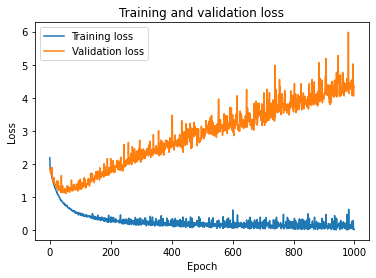

In [40]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_validation.png')
plt.show()

54/54 [==============================] - 1s 5ms/step - loss: 4.3495 - accuracy: 0.6672
Accuracy of the fucking model on the fucking test data is :  66.72453880310059 %


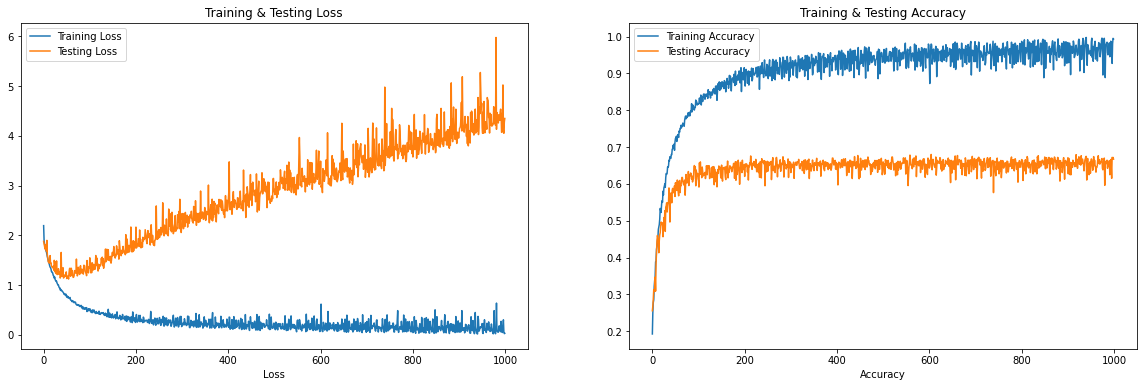

In [41]:
print("Accuracy of the fucking model on the fucking test data is : " , model.evaluate(x_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss , label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].set_xlabel("Epochs")
ax[0].set_xlabel("Loss")
ax[0].legend()

ax[1].plot(train_acc , label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].set_xlabel("Epochs")
ax[1].set_xlabel("Accuracy")
ax[1].legend()
plt.savefig('training_testing.png')
plt.show()


In [42]:
# # predicting on test data.
# emotion_labels = {
#     0: 'angry',
#     1: 'calm',
#     2: 'disgust',
#     3: 'fear',
#     4: 'happy',
#     5: 'neutral',
#     6: 'sad',
#     7: 'surprise'
# }

# pred_test = model.predict(x_test)
# dt_pred_test = pd.DataFrame(pred_test)
# dt_pred_test['maxValueColumnId'] = dt_pred_test.idxmax(axis=1)
# dt_pred_test['predictedLabel'] = dt_pred_test['maxValueColumnId'].map(emotion_labels)
# dt_pred_test['actualLabel'] = y_test.flatten()
# dt_pred_test

In [43]:
# print(classification_report(y_test, y_pred))